# Practice Project - Recommendation Systems: Amazon Product Reviews

## **Marks: 40**

__________

Welcome to the Practice Project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
### Context: 
--------------

E-commerce websites like Amazon, Flipkart uses different recommendation models to provide personalized suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
### Objective:
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [4]:
# uncomment if you are using google colab

# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

### Importing Libraries
#### One of the first steps in any data science task is importing the necessary tools you will use.

In [5]:
# installing surprise library, only do it for first time
!pip install surprise

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

# for implementing cross validation
from surprise.model_selection import KFold

### Loading the data

In [8]:
#col_names = ['user_id', 'item_id', 'rating', 'timestamp']
rating = pd.read_csv('ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])
rating = rating.drop('timestamp', axis=1)

Let's check the **info** of the data

In [9]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   item_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


- There are **7824482 observations** and **4 columns** in the data
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [ ]:
#Dropping timestamp column
#rating = rating.drop(['timestamp'], axis=1)

### **Question 1: Exploring the dataset (7 Marks)**

#### Q 1.1 Print the top 5 rows of the dataset (1 Mark)

In [10]:
#printing the top 5 rows of the dataset
rating.head()

,user_id,item_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


#### Q 1.2 Describe the distribution of ratings. (1 Mark)

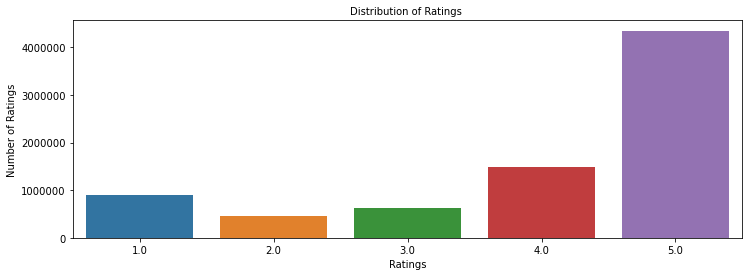

In [11]:
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

**Write your Answer here:**

- About Data -> There 3 Features {User ID, Item ID, & Rating} and 100000 rows in the dataset. There are 7824482 ratings in the dataset.*

- As per Histogram, Rating '5' has highest count of ratings (>4000k).Rating '4' being second with 1300K+ and Rating '3' being third in count of ratings with a little over 500K.

- The ratings are biased towards 4, & 5 more than 1,2 & 3.

In [12]:
df=rating.copy()

**As this dataset is very large and has 7824482 observations, it is not computationally possible to build a model using this.Moreover, there are many users who have only rated a few products and also there are products which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumption.**

Here, We will be taking users who have given at least 50 rating, and the products who has at least 5 rating, as when we shop online we prefer to have some number of rating of a product. 

In [13]:
# Get the column containing the users
users = rating.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [14]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = rating.loc[~rating.user_id.isin(remove_users)]

In [15]:
rating.shape

(125871, 3)

In [16]:
# Get the column containing the users
users = rating.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [17]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = rating.loc[~rating.item_id.isin(remove_users)]

In [18]:
rating.shape

(65290, 3)

#### Q 1.3 What is the total number of unique users and unique items? (1 Mark)

In [19]:
#Finding number of unique users
rating['user_id'].nunique()

1540

**Write your Answer here:**

- There are **1540 users** in the dataset

In [20]:
#Finding number of unique items
rating['item_id'].nunique()

5689

**Write your Answer here:**

- There are **5689 items** in the dataset
- As per the number of unique users and items, there is a **possibility of 1540 * 5689 = 8761060
 ratings** in the dataset. But **we only have 65290 ratings**, i.e. not every user has rated every item in the dataset. And we can build a recommendation system to recommend items to users which they have not interacted with.

#### Q 1.4 Is there any item that has been interacted with more than once by the same user?

In [21]:
rating.groupby(['user_id', 'item_id']).count()

rating
user_id        item_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [22]:
rating.groupby(['user_id', 'item_id']).count()['rating'].sum()

65290

**Write your Answer here:**

- The **sum is equal to the total number of observations** which implies that **there is only interaction between a pair of items and a user**.

#### Q 1.5  Which one is the most interacted item in the dataset?(1 Mark)

In [ ]:
rating['item_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: item_id, Length: 5689, dtype: int64

**Write your Answer here:**

- The **Item with ItemId: B0088CJT4U has been interacted by most users** which is **206** times.
- But still, there is a possibility of 1540-206 = 1334 more interactions as we have 1540 unique users in our datasets. For those 1334 remaining users, we can build a recommendation system to predict who is most likely to interact with the item.

Also, out of these 1334 interactions, we need to consider the distribution of ratings as well.

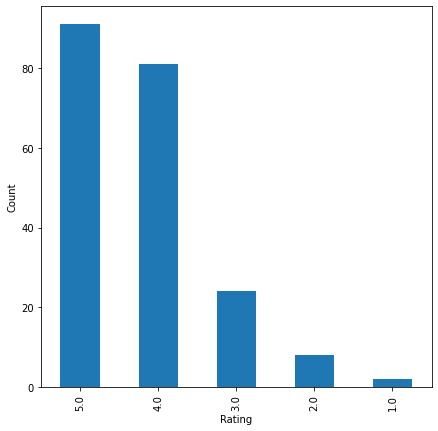

In [23]:
#Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(7,7))

rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Write your Answer here:**

- We can see that **this item has been liked by the majority of users**, as the count of ratings 5 and 4 is higher than the count of other ratings. 
- There can be items with very high interactions but the count of ratings 1 and 2 may be much higher than 4 or 5 which would imply that the item is disliked by the majority of users.

#### Q 1.6 Which user interacted the most with any item in the dataset? (1 Mark)

In [24]:
rating['user_id'].value_counts()

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64

**Write your Answer here:**

- The user with **userId: ADLVFFE4VBT8** has interacted with the most number of items i.e. **295** times. 
- But still, there is a possibility of 5689-295 = 5394 more interactions as we have 5689 unique items in our dataset. For those **5394** remaining items, we can build a recommendation system to predict which items are most likely to be watched by this user.

#### Q 1.7 What is the distribution of the user-item interactions in this dataset?(1 Mark)

In [25]:
#Finding user-item interactions distribution
count_interactions = rating.groupby('user_id').count()['item_id']
count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: item_id, Length: 1540, dtype: int64

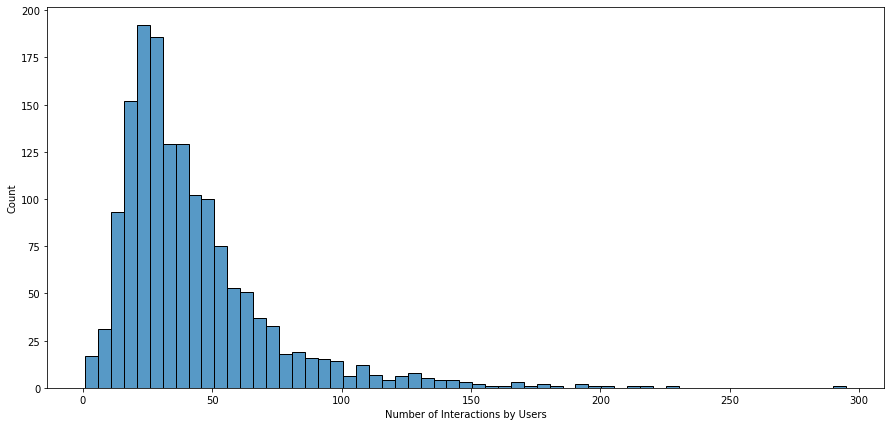

In [27]:
#Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Write your Answer here:**
- The distribution is higher skewed to the right. Only a few users interacted with more than 50 items. 

#### As we have now explored the data, let's start building Recommendation systems

### **Question 2: Create Rank-Based Recommendation System (3 Marks)**

### Model 1: Rank Based Recommendation System

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend items to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend items to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each item and then rank them based on their average rating.

In [36]:
#Calculating average ratings
average_rating = rating.groupby('item_id').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('item_id').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [37]:
final_rating.head()

,avg_rating,rating_count
item_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


Now, let's create a function to find the **top n items** for a recommendation based on the average ratings of items. We can also add a **threshold for a minimum number of interactions** for a item to be considered for recommendation. 

In [38]:
def top_n_items(data, n, min_interaction=30):
    
    #Finding items with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get items to recommend

#### Recommending top 5 items with 50 minimum interactions based on popularity

In [39]:
list(top_n_items(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Now that we have seen how to apply the Rank-Based Recommendation System, let's apply Collaborative Filtering Based Recommendation System

### Model 2: Collaborative Filtering Based Recommendation System (7 Marks)

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
- Model based

Below we are building similarity based recommendation system using `cosine` similarity and using KNN to find similar users which are nearest neighbor to the given user. 

We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library

Below we are loading the `rating` dataset, which is a pandas dataframe, into a different format called `surprise.dataset.DatasetAutoFolds` which is required by this library. To do this we will be using the classes `Reader` and `Dataset`

In [40]:
from sklearn.preprocessing import LabelEncoder
df=rating[['user_id','item_id']].apply(LabelEncoder().fit_transform)
df['rating']=rating['rating']
df.head()

,user_id,item_id,rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0


#### Making the dataset into surprise dataset and splitting it into train and test set

In [41]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

### Now we are ready to build the first baseline similary based recommendation system using cosine similarity and KNN

In [60]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0552


1.0551559636074466

#### Q 3.1 What is the RMSE for baseline user based collaborative filtering recommendation system? (1 Mark)

**Wite your Answer here:**

As we can see from above, these baseline model has `RMSE=1.05` on test set, we will try to improve this number later by using `GridSearchCV` tuning different hyperparameters of this algorithm

#### Q 3.2 What is the Predicted  rating for an user with userId=0 and for itemId= 3906 and itemId=100? (1 Mark)

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` as shown below

In [61]:
algo_knn_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your Answer here:**

As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.29 by this similarity based baseline model

Below we are predicting rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=100`, as shown below - 

In [62]:
algo_knn_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

**Write your Answer here:**

As we can see the estimated rating for this user-item pair is 4.0 based on this similarity based baseline model

### Improving similarity based recommendation system by tuning its hyper-parameters

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

#### Q 3.3 Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system? (3 Marks)

In [63]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9726612263875548
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [64]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.975611,0.979191,0.979685,0.978162,0.001816,18,0.727659,0.727116,0.729115,0.727963,0.000844,1,0.201287,0.006034,0.867109,0.013977,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.970760,0.976639,0.976745,0.974715,0.002797,9,0.729324,0.729246,0.731425,0.729999,0.001009,6,0.768438,0.032572,0.854533,0.018424,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.967189,0.977760,0.973557,0.972835,0.004346,5,0.744841,0.748593,0.745591,0.746342,0.001621,7,0.207210,0.019564,0.881213,0.030741,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.966785,0.977914,0.973953,0.972884,0.004606,6,0.747206,0.751759,0.748235,0.749067,0.001950,12,0.712784,0.006407,0.891414,0.015609,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.973059,0.982434,0.976670,0.977388,0.003860,12,0.758210,0.762217,0.757597,0.759341,0.002049,13,0.183482,0.015196,0.901733,0.015675,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now we will building final model by using tuned values of the hyperparameters which we received by using grid search cross validation

In [65]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9887


0.988698949219415

**Write your Answer here:**

We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.98 from 1.05. We can say that we have been able to improve the model after hyperparameter tuning

#### Q 3.4  What is the Predicted  rating for an user with userId=0 and for itemId= 3906 and itemId=100 using tuned user based collaborative filtering? (1 Mark)

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [66]:
similarity_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

If we compare the above predicted rating, we can see the baseline model predicted rating as `4.29` and the optimized model predicted the rating as `4.29`.

Below we are predicting rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=100`, by using the optimized model as shown below - 

In [67]:
similarity_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

If we compare the above predicted rating, we can see the baseline model predicted rating as `4` and the optimized model predicted the rating as `4.29`.

#### Identifying similar users to a given user (nearest neighbors)

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=0` based on the `msd` distance metric

In [68]:
similarity_algo_optimized.get_neighbors(0, k=5)

[7, 12, 14, 23, 47]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [69]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended item ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the item id which user_id has not interacted yet
    for item_id in non_interacted_items:
        
        # predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating items for this user

#### Predicted top 5 items for userId=4 with similarity based recommendation system

In [70]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized)

#### Q 3.5 Predict the top 5 items for userId=4 with similarity based recommendation system (1 Mark)

In [71]:
recommendations

[(850, 5),
 (2857, 4.875),
 (2277, 4.856530910239044),
 (2722, 4.833333333333333),
 (4189, 4.833053684165744)]

### Model 3 Item based Collaborative Filtering Recommendation System (7 Marks)

In [72]:
#definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

#defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0697


1.0697030922594737

#### Q 4.1 What is the RMSE for baseline item based collaborative filtering recommendation system ?

**Write your Answer here:**
- As we can see from above, these baseline model has `RMSE=1.06` on test set, we will try to improve this number later by using `GridSearchCV` tuning different hyperparameters of this algorithm

#### Let's us now predict rating for an user with `userId=0` and for `itemId=3906` and `itemId=100`

In [73]:
algo_knn_item.predict(0, 3096, r_ui=4, verbose=True)

user: 0          item: 3096       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3096, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.29 by this similarity based baseline model

#### Let's predict  the rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=22607`

In [74]:
algo_knn_item.predict(0, 100, verbose=True)

user: 0          item: 100        r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

As we can see the estimated rating for this user-item pair is 5.00 based on this similarity based baseline model

#### Q 4.3 Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system?  (3 Marks)

In [75]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above:

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [58]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.991301,0.988357,0.987169,0.988942,0.001737,16,0.731162,0.727938,0.725287,0.728129,0.002402,1,0.958323,0.077266,1.131068,0.052381,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,0.989719,0.989027,0.987820,0.988855,0.000785,15,0.737714,0.734467,0.732658,0.734946,0.002092,6,2.557845,0.472887,1.317904,0.217815,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.976114,0.978067,0.973682,0.975954,0.001793,1,0.743538,0.744871,0.739285,0.742565,0.002382,7,0.979231,0.127724,1.215416,0.234608,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,0.978645,0.979575,0.976028,0.978083,0.001502,9,0.750129,0.749935,0.745465,0.748510,0.002154,12,2.074108,0.149254,1.288441,0.102950,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.976797,0.978460,0.973397,0.976218,0.002107,4,0.755837,0.756199,0.749669,0.753902,0.002996,13,1.047686,0.204148,1.306734,0.290950,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


In [59]:

# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9896


0.9895877571156905

**Write your Answer here:**
- We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.98 from 1.06. We can say that we have been able to improve the model after hyperparameter tuning.

#### Q 4.4 What is the Predicted rating for an item with userId=0 and for itemId= 3906 and itemId=100 using tuned item based collaborative filtering? (1 Mark)

#### Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [76]:
similarity_algo_optimized_item.predict(0, 3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your Answer here:**
- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.29` and the optimized model predicted the rating as `4.29`. whereas the actual rating is `4.0`, i.e. predicted rating from the optimized model is closer to the actual rating.

#### Let's predict the rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=100`, by using the optimized model:

In [77]:
similarity_algo_optimized_item.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your Answer here:**
- If we compare the above predicted rating, we can see the baseline model predicted rating as `5` and the optimized model predicted the rating as `4.29`.

#### Identifying similar users to a given user (nearest neighbors)
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [78]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[132, 213, 473, 1636, 393]

#### Predicted top 5 items for userId=4 with similarity based recommendation system

In [79]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_item)

#### Q 4.5 Predict the top 5 items for userId=4 with similarity based recommendation system ? (1 Mark) 

In [80]:
recommendations

[(5155, 4.846153846153846),
 (1997, 4.701088473346358),
 (3975, 4.692622950819672),
 (4253, 4.612068965517241),
 (5489, 4.536817102137767)]

### Model 4 Based Collaborative Filtering - Matrix Factorization using SVD (7 Marks)

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

#### Singular Value Decomposition (SVD)

SVD is used to compute the latent features from the user-item matrix that we already learned earlier. But SVD does not work when we missing values in the user-item matrix.

#### Building a baseline matrix factorization recommendation system

In [81]:
# using SVD matrix factorization
algo_svd = SVD()

# training the algorithm on the trainset
algo_svd.fit(trainset)

# predicting ratings for the testset
predictions = algo_svd.test(testset)

# computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9297


0.9296539310553363

#### Q 5.1 What is the RMSE for baseline SVD based collaborative filtering recommendation system? (1 Mark)

**Write your Answer here:**

We can that the baseline RMSE for matrix factorization model on testset (which is `0.93`) is lower as compared to the RMSE for baseline similarity based recommendation system (which is `1.06`) and it is even lesser than the RMSE for optimized similarity based recommendation system (which is `0.99`)

#### Q 5.2 What is the Predicted  rating for an user with userId =0 and for itemId= 3906 and itemId=100? (1 Mark)

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` as shown below

In [82]:
algo_svd.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.53   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.529676906275727, details={'was_impossible': False})

**Write your Answer here:**

As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.75 by this matrix factorization based baseline model. It seems like we have over estimated the rating by a small margin. We will try to fix this later by tuning the hyperparameters of the model using GridSearchCV

Below we are predicting rating for the same `userId=0` but for a item which this user has not interacted before i.e. `userId=100`, as shown below - 

In [83]:
algo_svd.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.74   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.738974012866132, details={'was_impossible': False})

**Write your Answer here:**

We can see that estimated rating for this user-item pair is 4.41 based on this matrix factorization based baseline model.

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

#### Q 5.3 Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system? (3 Marks)

In [84]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8976550051164853
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [85]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.959448,0.954090,0.948138,0.953892,0.004619,25,0.741082,0.737494,0.734732,0.737770,0.002600,25,2.333606,0.113486,0.315096,0.023362,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.959996,0.953718,0.948614,0.954109,0.004655,26,0.742526,0.738554,0.735678,0.738919,0.002808,26,2.381112,0.126732,0.349003,0.013968,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.961444,0.954857,0.948379,0.954893,0.005334,27,0.745436,0.740438,0.736567,0.740814,0.003631,27,2.464307,0.090633,0.345940,0.014300,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.918163,0.913517,0.904212,0.911964,0.005800,16,0.688206,0.685906,0.680487,0.684866,0.003236,16,2.390977,0.032135,0.345091,0.034576,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.919290,0.913665,0.905747,0.912901,0.005556,17,0.693212,0.689852,0.685175,0.689413,0.003296,17,2.376237,0.026192,0.316545,0.007213,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now we will building final model by using tuned values of the hyperparameters which we received by using grid search cross validation

In [86]:
# building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)

# training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# computing RMSE
accuracy.rmse(predictions)

RMSE: 0.9235


0.9235198725006638

#### Q 5.4 What is the Predicted rating for an user with userId=0 and for itemId= 3906 and itemId=100 using SVD based collaborative filtering? (1 Mark)

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [87]:
svd_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.79   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.791762485444303, details={'was_impossible': False})


**Write your Answer here:**

If we compare the above predicted rating, we can see the baseline model predicted rating as `4.75` and the optimized model predicted the rating as `4.79`. whereas the actual rating is `4`.

In [88]:
svd_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.65   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.645924352467011, details={'was_impossible': False})

#### Q 5.5 Predict the top 5 items for userId=4 with SVD based recommendation system ?

In [89]:
get_recommendations(df,4, 5, svd_algo_optimized)

[(1309, 5),
 (1609, 4.99154105781195),
 (920, 4.983430792501032),
 (5194, 4.979384808224706),
 (1249, 4.972395048997566)]

### Predicting ratings for already interacted items

Below we are comparing the rating predictions of users for those items which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [90]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # creating an empty list to store the recommended item ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # extracting those item ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # looping through each of the item id which user_id has interacted already
    for item_id in interacted_items:
        
        # extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['itemId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating items for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=4`

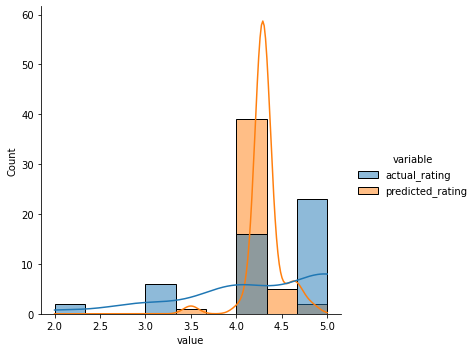

In [91]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, similarity_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

**Write your Answer here:**

- We can see that distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings are nearly same as to the total bins for actual ratings.
- We are getting more predicted values in between 4 and 5,this is expected, as actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values as we are taking aggregated ratings from the nearest neighbors of a given user. But over the predictions looks good as compared to the distribution of actual ratings.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=4`

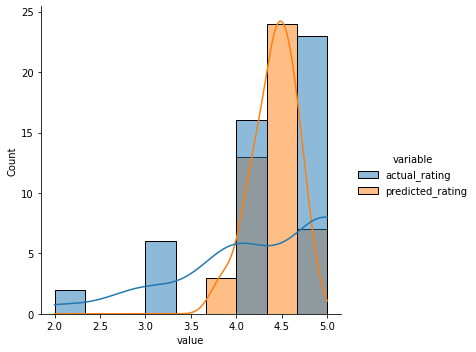

In [92]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, svd_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

In [94]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(rating[['user_id', 'item_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## Precision and Recall @ k

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

To know more about precision recall in Recommendation systems refer to these links : 

https://surprise.readthedocs.io/en/stable/FAQ.html

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

### Question6: Compute the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values. Do you note anything interesting about these values?  (4 Marks)

In [95]:
from collections import defaultdict
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [96]:
# Make list of k values
#A basic cross-validation iterator.
from surprise.model_selection import KFold
kf = KFold(n_splits=5)
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]


for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.87
-----> Recall:  0.689
> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.857
-----> Recall:  0.698
> k=5, model=KNNBasic
-----> Precision:  0.835
-----> Recall:  0.66
> k=5, model=KNNBasic
-----> Precision:  0.843
-----> Recall:  0.688
> k=5, model=SVD
-----> Precision:  0.868
-----> Recall:  0.697
> k=5, model=SVD
-----> Precision:  0.87
-----> Recall:  0.696
> k=10, model=KNNBasic
-----> Precision:  0.853
-----> Recall:  0.86
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done comp


* Collaborative Filtering using user-user based interaction performed well in both the k values with Precision value ~84% (k=10) and with k=5, ~86%.

* Tuned SVD has better RMSE than all models but Collaborative Filtering using user-user based interaction is also giving good results based on Precsion and recall @k for K=10. 

* The final model will denpend on the business requirements as whether they have to minimize RMSE or go with maximizing Precision/Recall. 

### Question 7 ( 5 Marks)
#### 7.1 Compare the results from the base line user-user and item-item based models.
#### 7.2 How do these baseline models compare to each other with respect to the tuned user-user and item-item models?
#### 7.3 The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE and precision recall for the models.
#### 7.4 Does it improve? Can you offer any reasoning as to why that might be?

**Write your Answer here:**

- User-based and Item-based Collaborative Models have nearly same. User based RMSE values (1.05) while the "Item based" model's RMSE is 1.06. Clearly, tuned Collaborative Filtering Models have performed better than baseline model and the user-user based tuned model is performing better and have  rmse of 0.9887

- The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative filtering performed well.

- Collaborative Filtering searches for neighbors based on similarity of item (example) preferences and recommend items that those neighbors interacted while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- RMSE for Matrix Factorization (0.92) is better than the Collaborative Filtering Models (~1.00).
- Tuning SVD matrix factorization model is not improving the base line SVD much.  
- Matrix Factorization has lower RMSE due to the reason that it assumes that both items and users are present in some low dimensional space describing their properties and recommend a item based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

### Conclusions

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.

In [97]:
import pickle
pickle.dump(svd_algo_optimized, open('svd_algo_optimized.pkl', 'wb'))